# Benchmark Results Visualization

This notebook visualizes the results from `benchmark_results.csv`.
We will analyze:
1. Throughput vs Model Size
2. Latency vs Model Size
3. Comparison between different models

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style to a modern look
sns.set_theme(style="whitegrid", context="notebook", font_scale=1.1)

# Load data
df = pd.read_csv("benchmark_res.csv")

# Handle missing status (for backward compatibility)
if "status" not in df.columns:
    df["status"] = "success"

# Fill NaN for OOM rows if needed (though they should be NaN already)
# We want to keep them for OOM visualization

# Sort by model parameters
df = df.sort_values("model_params_millions")

# Group by model_name, mode, AND context_length
# We take the last run for each configuration
latest_df = (
    df.groupby(["model_name", "mode", "context_length"])
    .last()
    .reset_index()
    .sort_values(["model_params_millions", "context_length"])
)

# Define model order for consistent plotting
model_order = ["small", "medium", "large", "xl", "2_7B"]
existing_models = [m for m in model_order if m in latest_df["model_name"].unique()]

latest_df.head()

,model_name,mode,context_length,timestamp,experiment_name,git_hash,vocab_size,d_model,num_layers,num_heads,d_ff,batch_size,precision,compile,avg_time_ms,throughput_samples_per_sec,model_params_millions,peak_memory_gb,status
6,small,forward_backward,128,2025-12-06T06:57:17.768035,compile_impact_study,b782baf,10000,768,12,12,3072,4,fp32,False,71.228224,56.157514,120.945408,2.451492,success
9,small,forward_only,128,2025-12-06T06:56:32.953646,compile_impact_study,b782baf,10000,768,12,12,3072,4,fp32,False,19.957829,200.422599,120.945408,0.513537,success
7,small,forward_backward,512,2025-12-06T06:58:20.205726,compile_impact_study,b782baf,10000,768,12,12,3072,4,fp32,False,138.256210,28.931793,120.945408,5.023371,success
10,small,forward_only,512,2025-12-06T06:57:42.269650,compile_impact_study,b782baf,10000,768,12,12,3072,4,fp32,False,43.645607,91.647254,120.945408,0.713305,success
8,small,forward_backward,1024,2025-12-06T06:59:30.465393,compile_impact_study,b782baf,10000,768,12,12,3072,4,fp32,False,313.896093,12.743070,120.945408,10.896996,success


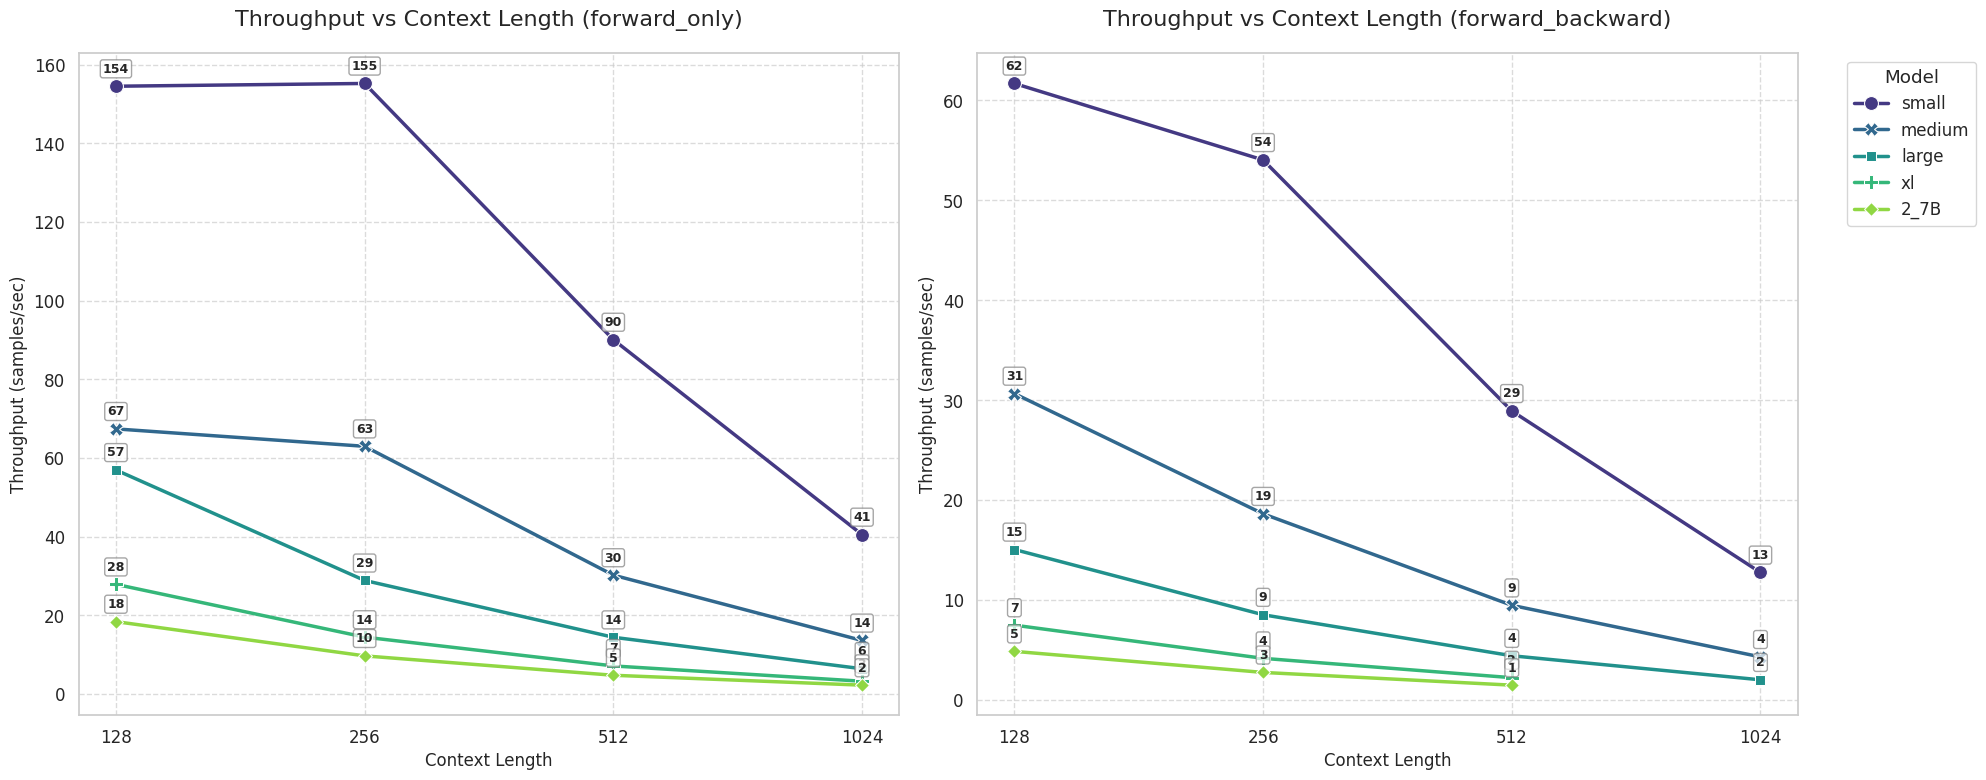

In [18]:
# Plot Throughput vs Context Length (Side by Side)
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=False)
modes = ["forward_only", "forward_backward"]

for i, mode in enumerate(modes):
    ax = axes[i]
    # Filter for success runs only
    subset = latest_df[(latest_df["status"] == "success") & (latest_df["mode"] == mode)]

    if subset.empty:
        ax.text(0.5, 0.5, f"No data for {mode}", ha="center", va="center")
        continue

    sns.lineplot(
        data=subset,
        x="context_length",
        y="throughput_samples_per_sec",
        hue="model_name",
        hue_order=existing_models,
        style="model_name",
        markers=True,
        dashes=False,
        linewidth=2.5,
        palette="viridis",
        markersize=10,
        ax=ax,
        legend=(i == 1),  # Show legend only on the second plot to save space
    )

    # Add value labels
    for model_name in existing_models:
        model_subset = subset[subset["model_name"] == model_name]
        if model_subset.empty:
            continue

        for _, row in model_subset.iterrows():
            if not np.isnan(row["throughput_samples_per_sec"]):
                ax.annotate(
                    f"{row['throughput_samples_per_sec']:.0f}",
                    (row["context_length"], row["throughput_samples_per_sec"]),
                    textcoords="offset points",
                    xytext=(0, 10),
                    ha="center",
                    fontsize=9,
                    fontweight="bold",
                    bbox=dict(
                        boxstyle="round,pad=0.2", fc="white", ec="gray", alpha=0.7
                    ),
                )

    ax.set_title(f"Throughput vs Context Length ({mode})", fontsize=16, pad=20)
    ax.set_xlabel("Context Length", fontsize=12)
    ax.set_ylabel("Throughput (samples/sec)", fontsize=12)
    ax.set_xscale("log", base=2)
    if not subset.empty:
        ax.set_xticks(subset["context_length"].unique())
        ax.set_xticklabels(subset["context_length"].unique())
    ax.grid(True, linestyle="--", alpha=0.7)

    if i == 1:
        ax.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
    elif ax.get_legend():
        ax.get_legend().remove()

plt.tight_layout()
plt.show()

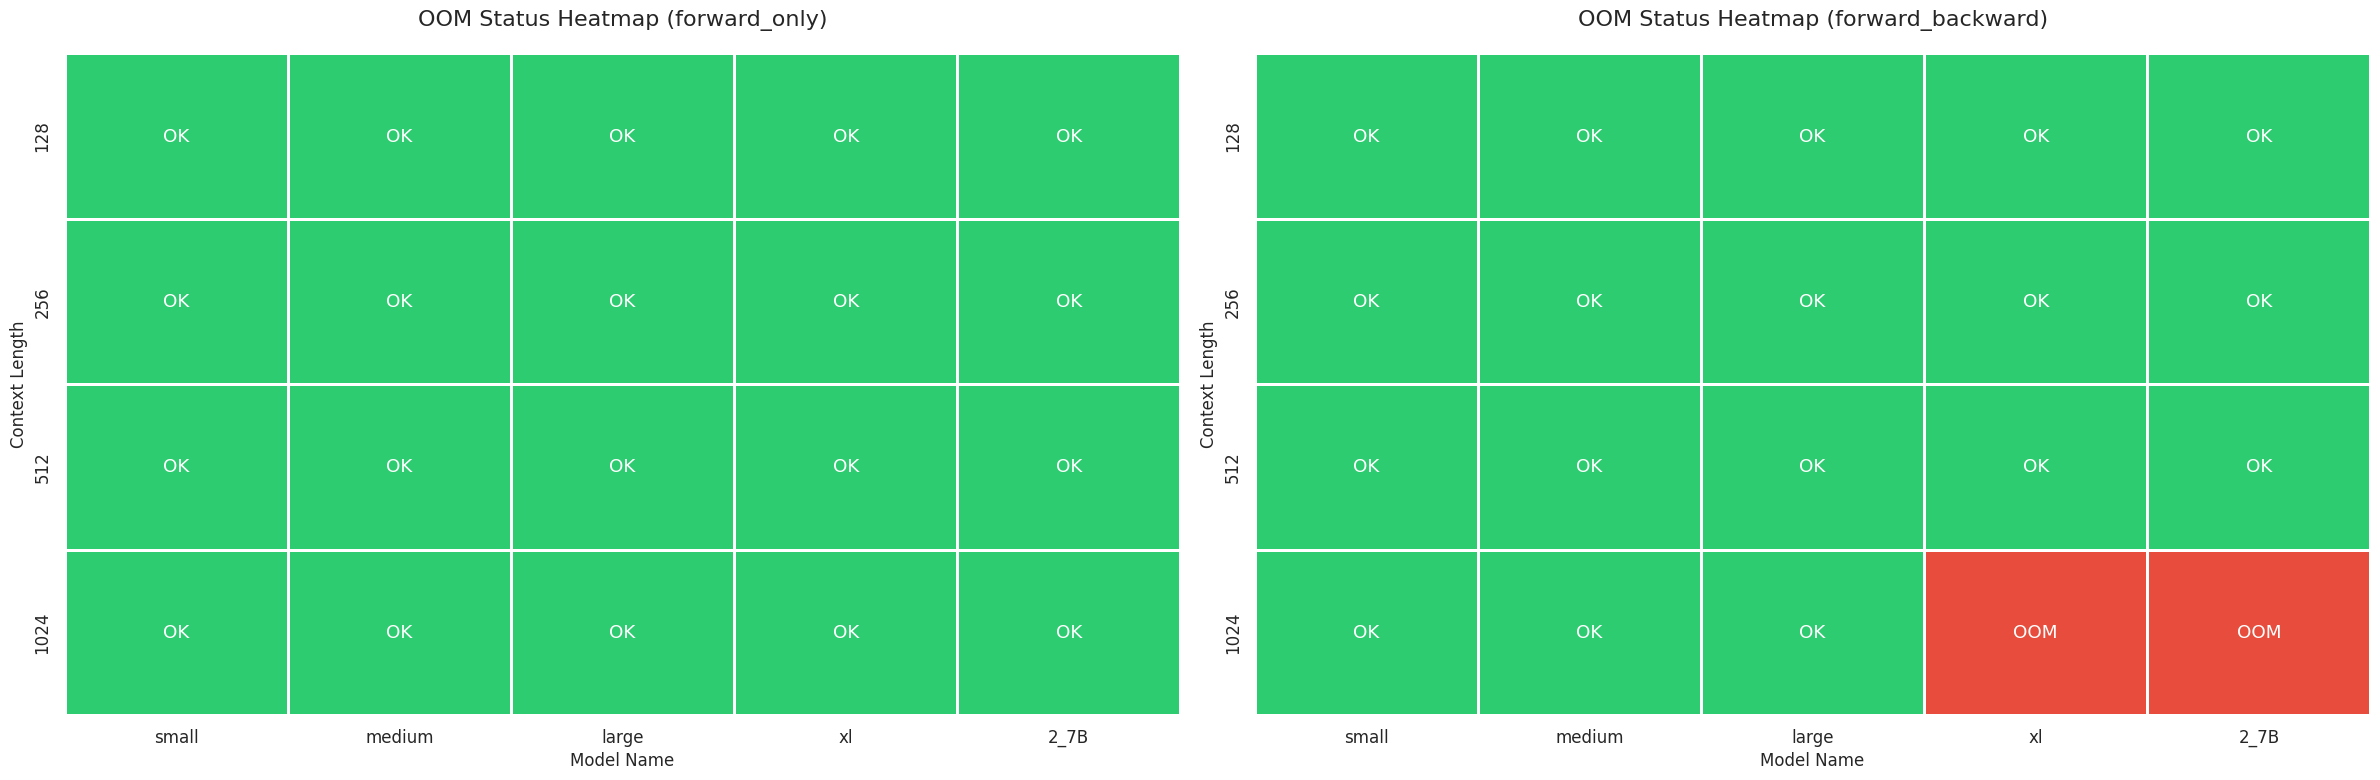

In [19]:
# OOM Status Visualization (Side by Side)
fig, axes = plt.subplots(1, 2, figsize=(24, 8))
modes = ["forward_only", "forward_backward"]

# Status map
status_map = {"success": 1, "oom": 0, "failed": -1}
viz_df = latest_df.copy()
viz_df["status_code"] = viz_df["status"].map(status_map).fillna(1)

cmap = sns.color_palette(["#e74c3c", "#2ecc71"])  # Red, Green
vmin, vmax = 0, 1

for i, mode in enumerate(modes):
    ax = axes[i]
    subset = viz_df[viz_df["mode"] == mode]

    if subset.empty:
        ax.text(0.5, 0.5, f"No data for {mode}", ha="center", va="center")
        continue

    pivot_status = subset.pivot(
        index="context_length", columns="model_name", values="status_code"
    )
    pivot_status = pivot_status.reindex(columns=existing_models)

    sns.heatmap(
        pivot_status,
        cmap=cmap,
        annot=True,
        fmt=".0f",
        cbar=False,
        linewidths=1,
        linecolor="white",
        vmin=vmin,
        vmax=vmax,
        ax=ax,
    )

    # Customizing annotations
    for text in ax.texts:
        if text.get_text() == "1":
            text.set_text("OK")
            text.set_color("white")
        elif text.get_text() == "0":
            text.set_text("OOM")
            text.set_color("white")

    ax.set_title(f"OOM Status Heatmap ({mode})", fontsize=16, pad=20)
    ax.set_xlabel("Model Name", fontsize=12)
    ax.set_ylabel("Context Length", fontsize=12)

plt.tight_layout()
plt.show()

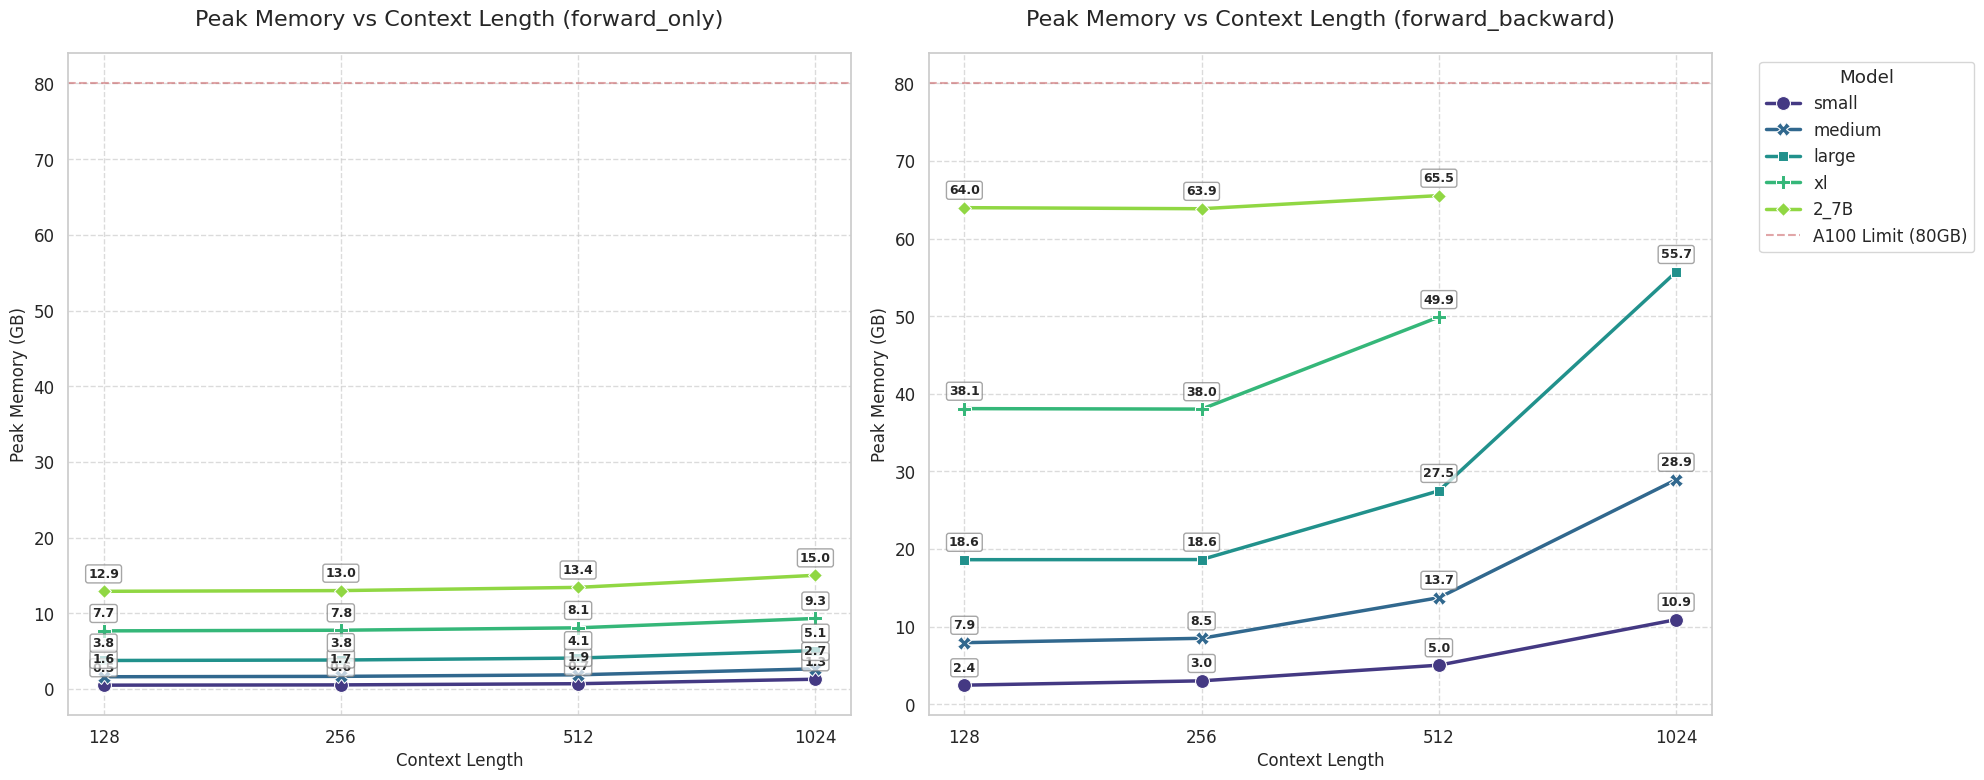

In [20]:
# Plot Peak Memory vs Context Length (Side by Side)
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
modes = ["forward_only", "forward_backward"]

for i, mode in enumerate(modes):
    ax = axes[i]
    subset = latest_df[latest_df["mode"] == mode]

    if subset.empty:
        ax.text(0.5, 0.5, f"No data for {mode}", ha="center", va="center")
        continue

    # Create the line plot
    sns.lineplot(
        data=subset,
        x="context_length",
        y="peak_memory_gb",
        hue="model_name",
        hue_order=existing_models,
        style="model_name",
        markers=True,
        dashes=False,
        linewidth=2.5,
        palette="viridis",
        markersize=10,
        ax=ax,
        legend=(i == 1),
    )

    # Add value labels
    # We iterate through each model group to add labels
    for model_name in existing_models:
        model_subset = subset[subset["model_name"] == model_name]
        if model_subset.empty:
            continue

        # Get color for this model from the plot
        # This is a bit tricky with seaborn, so we'll just use black or a neutral color
        # Or we can try to match the palette

        for _, row in model_subset.iterrows():
            if not np.isnan(row["peak_memory_gb"]):
                ax.annotate(
                    f"{row['peak_memory_gb']:.1f}",
                    (row["context_length"], row["peak_memory_gb"]),
                    textcoords="offset points",
                    xytext=(0, 10),
                    ha="center",
                    fontsize=9,
                    fontweight="bold",
                    bbox=dict(
                        boxstyle="round,pad=0.2", fc="white", ec="gray", alpha=0.7
                    ),
                )

    ax.set_title(f"Peak Memory vs Context Length ({mode})", fontsize=16, pad=20)
    ax.set_xlabel("Context Length", fontsize=12)
    ax.set_ylabel("Peak Memory (GB)", fontsize=12)
    ax.set_xscale("log", base=2)
    if not subset.empty:
        ax.set_xticks(subset["context_length"].unique())
        ax.set_xticklabels(subset["context_length"].unique())
    ax.grid(True, linestyle="--", alpha=0.7)

    # Add limit line
    ax.axhline(y=80, color="r", linestyle="--", alpha=0.5, label="A100 Limit (80GB)")

    if i == 1:
        ax.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
    elif ax.get_legend():
        ax.get_legend().remove()

plt.tight_layout()
plt.show()

# Torch.compile Impact Study

Here we analyze the impact of `torch.compile` on throughput and memory usage.
We filter for the experiment `compile_impact_study`.

In [ ]:
# Filter for compile impact study
compile_df = df[df["experiment_name"] == "compile_impact_study"].copy()

# Ensure 'compile' column exists and handle NaN
if "compile" not in compile_df.columns:
    compile_df["compile"] = "False"

# Convert to string to ensure consistent grouping (avoid mixed bool/str types)
compile_df["compile"] = compile_df["compile"].fillna("False").astype(str)

# Normalize True/False strings
compile_df["compile"] = compile_df["compile"].replace(
    {
        "True": "True",
        "False": "False",
        "1.0": "True",
        "0.0": "False",
        "1": "True",
        "0": "False",
    }
)

# Group by relevant columns
compile_viz_df = (
    compile_df.groupby(["model_name", "mode", "context_length", "compile"])
    .last()
    .reset_index()
    .sort_values(["model_params_millions", "context_length"])
)

print(f"Found {len(compile_viz_df)} runs for compile impact study")
print(f"Compile values: {compile_viz_df['compile'].unique()}")
compile_viz_df.head()

Found 24 runs for compile impact study
Compile values: ['False' 'True']


,model_name,mode,context_length,compile,timestamp,experiment_name,git_hash,vocab_size,d_model,num_layers,num_heads,d_ff,batch_size,precision,avg_time_ms,throughput_samples_per_sec,model_params_millions,peak_memory_gb,status
12,small,forward_backward,128,False,2025-12-06T06:57:17.768035,compile_impact_study,b782baf,10000,768,12,12,3072,4,fp32,71.228224,56.157514,120.945408,2.451492,success
13,small,forward_backward,128,True,2025-12-06T06:57:09.092565,compile_impact_study,b782baf,10000,768,12,12,3072,4,fp32,37.394680,106.967087,120.945408,2.443664,success
18,small,forward_only,128,False,2025-12-06T06:56:32.953646,compile_impact_study,b782baf,10000,768,12,12,3072,4,fp32,19.957829,200.422599,120.945408,0.513537,success
19,small,forward_only,128,True,2025-12-06T06:56:27.879930,compile_impact_study,b782baf,10000,768,12,12,3072,4,fp32,11.943052,334.922765,120.945408,0.520740,success
14,small,forward_backward,512,False,2025-12-06T06:58:20.205726,compile_impact_study,b782baf,10000,768,12,12,3072,4,fp32,138.256210,28.931793,120.945408,5.023371,success


/tmp/ipykernel_2440764/3803830368.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["config_label"] = (
/tmp/ipykernel_2440764/3803830368.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["config_label"] = (


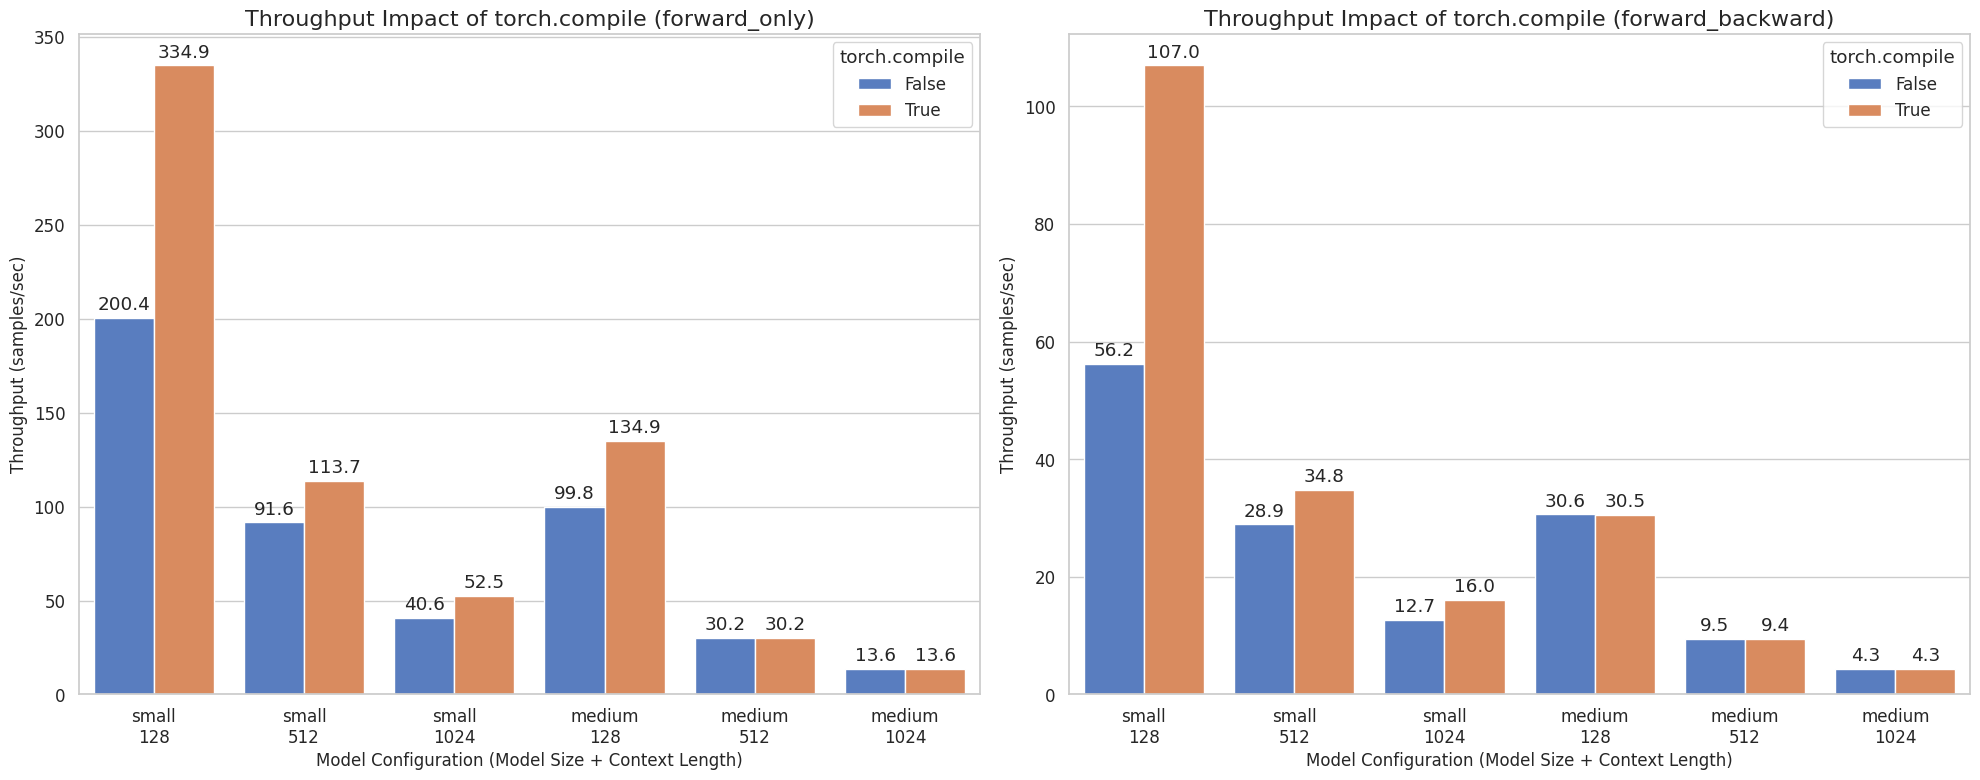

In [42]:
# Plot Throughput: Compile vs No Compile
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=False)
modes = ["forward_only", "forward_backward"]

for i, mode in enumerate(modes):
    ax = axes[i]
    subset = compile_viz_df[compile_viz_df["mode"] == mode]

    if subset.empty:
        ax.text(0.5, 0.5, f"No data for {mode}", ha="center", va="center")
        continue

    # Create a composite x-axis label for (Model, Context)
    subset["config_label"] = (
        subset["model_name"] + "\n" + subset["context_length"].astype(str)
    )

    sns.barplot(
        data=subset,
        x="config_label",
        y="throughput_samples_per_sec",
        hue="compile",
        palette="muted",
        ax=ax,
    )

    # Add value labels
    for container in ax.containers:
        ax.bar_label(container, fmt="%.1f", padding=3)

    ax.set_title(f"Throughput Impact of torch.compile ({mode})", fontsize=16)
    ax.set_xlabel("Model Configuration (Model Size + Context Length)", fontsize=12)
    ax.set_ylabel("Throughput (samples/sec)", fontsize=12)
    ax.legend(title="torch.compile")

plt.tight_layout()
plt.show()

/tmp/ipykernel_2440764/3664335991.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["config_label"] = (
/tmp/ipykernel_2440764/3664335991.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["config_label"] = (


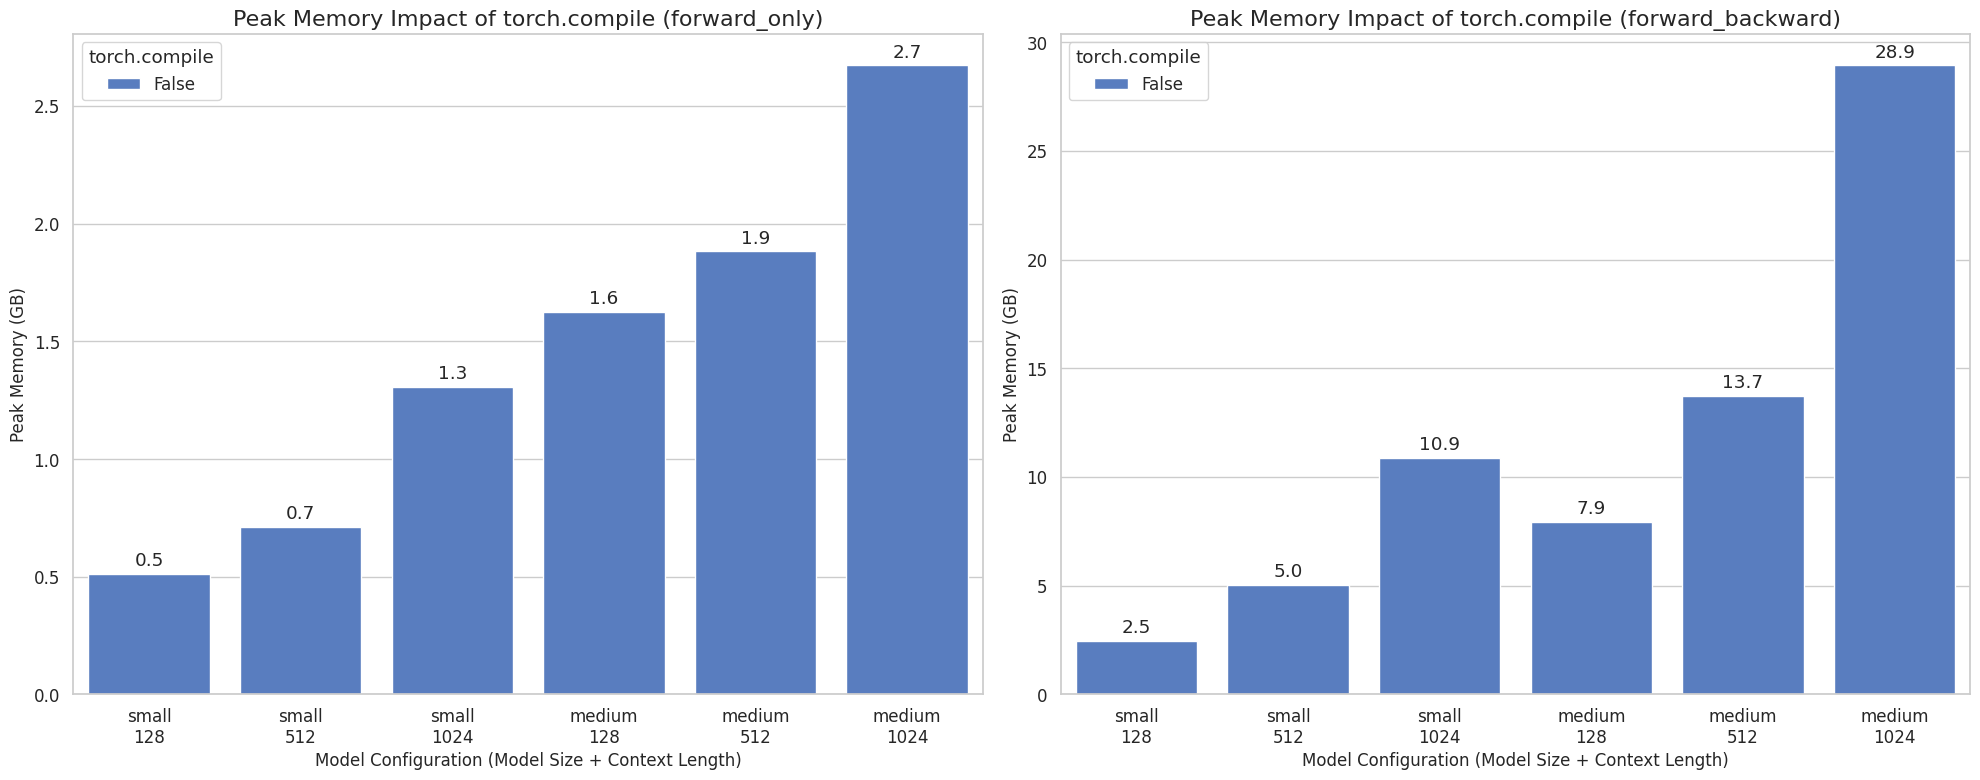

In [37]:
# Plot Peak Memory: Compile vs No Compile
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=False)

for i, mode in enumerate(modes):
    ax = axes[i]
    subset = compile_viz_df[compile_viz_df["mode"] == mode]

    if subset.empty:
        ax.text(0.5, 0.5, f"No data for {mode}", ha="center", va="center")
        continue

    subset["config_label"] = (
        subset["model_name"] + "\n" + subset["context_length"].astype(str)
    )

    sns.barplot(
        data=subset,
        x="config_label",
        y="peak_memory_gb",
        hue="compile",
        palette="muted",
        ax=ax,
    )

    # Add value labels
    for container in ax.containers:
        ax.bar_label(container, fmt="%.1f", padding=3)

    ax.set_title(f"Peak Memory Impact of torch.compile ({mode})", fontsize=16)
    ax.set_xlabel("Model Configuration (Model Size + Context Length)", fontsize=12)
    ax.set_ylabel("Peak Memory (GB)", fontsize=12)
    ax.legend(title="torch.compile")

plt.tight_layout()
plt.show()